<h1><center>Netflix Movies and TV Shows</center></h1>
<h3><center>Movies and TV Shows listings on Netflix</center></h3>

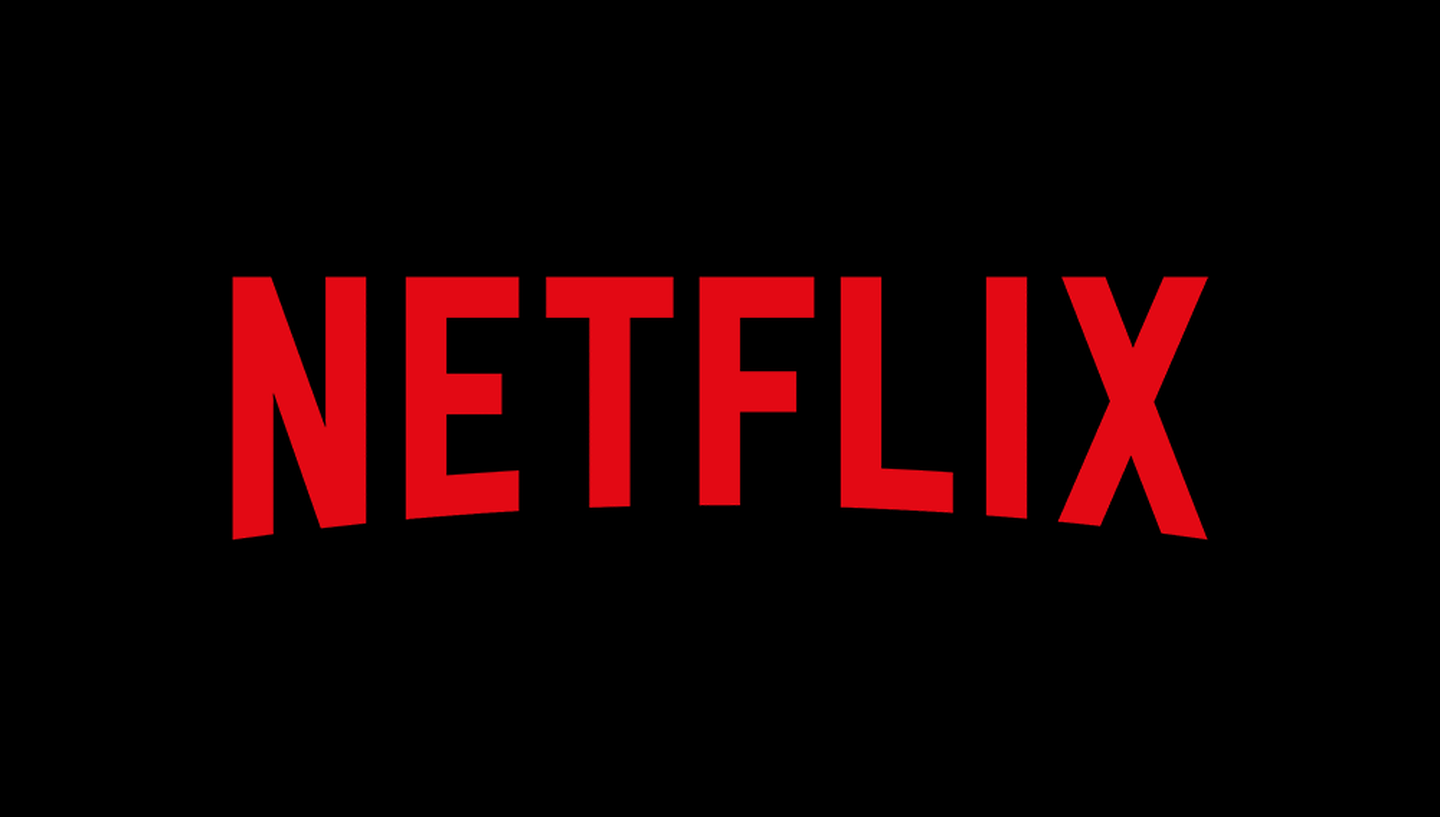

<h2><center>Goal/Aim</center></h2>

<b>Netflix is a subscription-based streaming service</b> that allows our members to watch TV shows and movies without commercials on an internet-connected device. You can also download TV shows and movies to your iOS, Android, or Windows 10 device and watch without an internet connection.
<br>
<br>
In this notebook, first we will do some <b>Exploratory Data Analysis (EDA)</b> to know and describe the data in a better way through interactive graphs and visualizations. Then we will build a multilabel classifier using <b>BERT and MLP</b> to predict the Genre of a show using its description.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

In [ ]:
net_df = pd.read_csv('../input/netflix-shows/netflix_titles.csv')
net_df.head()

In [ ]:
net_df.shape

In [ ]:
net_df.info()

In [ ]:
# Missing Values
msno.bar(net_df, figsize=(20,10))
plt.show()

#### Data Description
##### The dataset has 7787 rows and 12 columns:
* show_id: unique id of each show (not much of a use for us in this notebook)
* type: The category of a show, can be either a Movie or a TV Show
* title: Name of the show
* director: Name of the director(s) of the show
* cast: Name of actors and other cast of the show
* country: Name of countries the show is available to watch on Netflix
* date_added: Date when the show was added on Netflix
* release_year: Release year of the show
* rating: Show rating on netflix
* duration: Time duration of the show
* listed_in: Genre of the show
* description: Some text describing the show

##### Missing Values are found only in columns "director", "cast", "country"

<h2><center>Exploratory Data Analysis</center></h2>

In [ ]:
# Amount of content by country
countries = net_df['country'].value_counts()[net_df['country'].value_counts(normalize=True)> 0.005]
list_countries = list(countries.index)
plt.figure(figsize=(20,10))
plt.title('Amount of content by country', fontsize=18)
plt.tick_params(labelsize=14)
sns.barplot(y=countries.index, x=countries.values, alpha=0.6)
plt.show()

##### The largest amount of content is provided by America, followed by India and UK.

In [ ]:
# Movies and TV Shows count
movie_tvshows = net_df['type'].value_counts()
plt.figure(figsize=(14, 7))
plt.bar(movie_tvshows.index, movie_tvshows.values, alpha=0.8)
plt.title('Amount of movies and TV shows', fontsize=18)
plt.show()

In [ ]:
TVshows = net_df[net_df['type'] == 'TV Show']
Movie = net_df[net_df['type'] == 'Movie']
TVshows_progress = TVshows['release_year'].value_counts().sort_index()
Movie_progress = Movie['release_year'].value_counts().sort_index()
plt.figure(figsize=(14, 7))

plt.plot(TVshows_progress.index, TVshows_progress.values, label='TV shows')
plt.plot(Movie_progress.index, Movie_progress.values, label='Movie')

plt.axvline(2019, alpha=0.3, linestyle='--', color='r')
plt.axvline(2021, alpha=0.3, linestyle='--', color='r')
plt.axvspan(2019, 2021, alpha=0.2, color='r', label='Coronavirus')

plt.xticks(list(range(1925, 2026, 5)), fontsize=12)
plt.title('Content growth throughout history', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Amount of content', fontsize=14)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

##### The content amount grew before and during the coronavirus period.

In [ ]:
net_df.dropna(inplace=True)
rating = net_df['rating'].value_counts()
plt.figure(figsize=(14,7))
plt.title('Content ratings of the shows', fontsize=18)
plt.tick_params(labelsize=14)
sns.barplot(y=rating.index, x=rating.values, alpha=0.6)
plt.show()

##### Inference
The largest count of shows are made with the 'TV-MA' rating (2863 shows) "TV-MA": For mature audiences only.

Second largest is the 'TV-14' rating (1931 shows) "TV-14": May be inappropriate for children younger than 14 years of age.

Third largest is the 'TV-PG' rating (806 shows) "TV-PG": Parental guidance suggested

Fourth largest is the very popular 'R' rating (665 shows) "R": May be unsuitable for children under the age of 17 (Under 17 requires accompanying parent or adult guardian")

In [ ]:
grp = net_df.groupby('type')
movie = grp.get_group('Movie')
movie['duration'] = [int(i.split(' ')[0]) for i in movie.duration.dropna()]
plt.figure(figsize=(14, 7))
sns.distplot(movie['duration'], bins=60).set(ylabel=None)
plt.title('Length distribution of films', fontsize=18)
plt.xlabel('Duration', fontsize=14)
plt.show()

In [ ]:
short = movie.sort_values('duration')[['title', 'duration']].iloc[:20]
plt.figure(figsize=(14,7))
plt.title('Top 20 shortest movies available on Netflix', fontsize=18)
plt.tick_params(labelsize=14)
sns.barplot(y=short['title'], x=short['duration'], alpha=0.6)
plt.show()

In [ ]:
long = movie.sort_values('duration')[['title', 'duration']].iloc[-20:]
plt.figure(figsize=(14,7))
plt.title('Top 20 longest movies available on Netflix', fontsize=18)
plt.tick_params(labelsize=14)
sns.barplot(y=long['title'], x=long['duration'], alpha=0.6)
plt.show()

In [ ]:
directors = net_df['director'].value_counts()
plt.figure(figsize=(14,7))
plt.title('Top 10 directors available on Netflix', fontsize=18)
plt.tick_params(labelsize=14)
sns.barplot(y=directors.index[:10], x=directors.values[:10], alpha=0.6)
plt.show()

<h2><center>Model:BERT+MLP</center></h2>

#### Approach:
We'll be using transfer learning to get embeddings from pretrained BERT for each show's description. 
Next, we'll be training a MLP from the generated embeddings to predict the show genre.


#### Data
The input data here will be show description and the output labels will be the 42 Genres.
<br>
**Input data:** This will be the text describing a show
<br>
**Output labels:** This will be a vector of size 42 (since there are 42 genres) having values 0 or 1. 0 corresponding to a genre not present and 1 corresponding a genre present

In [ ]:
labels = np.hstack([np.array(i.split(', ')) for i in net_df.listed_in.dropna()])
unique = np.unique(labels)
def generate_label(x):
    genres = x.split(', ')
    label = np.zeros(shape=unique.shape)
    for i in genres:
        for j in range(len(unique)):
            if unique[j]==i:
                label[j]=1
    return label.astype(int)

In [ ]:
from tqdm.notebook import tqdm
data = pd.DataFrame()
data['text'] = net_df.dropna()['description']
data['title'] = net_df.dropna()['title']
data['label'] = [generate_label(x) for x in tqdm(net_df.dropna()['listed_in'])]
data[['text', 'label']].head()

In [ ]:
# Let's begin by checking the word length of show descriptions so that 
# we can trim and pad the texts to the same length for easy processing in the 
#future steps.
def get_wordlen(x): 
    return len(x.split())

data['len'] = data.text.apply(get_wordlen)
data['len'].plot(kind='hist')
plt.title('histogram of show description word length')
plt.xlabel('word length')
plt.show()
for i in np.arange(0.9,1,0.01):
    p = data.len.quantile(i)
    print(f'word length at {int(i*100)} percentile:',p)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[['text', 'title']], data['label'], test_size=0.3, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=33)
y_train.shape, y_val.shape, y_test.shape

In [ ]:
!pip install bert-tensorflow

In [ ]:
# importing necessary libraries
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import Model
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input
tf.get_logger().setLevel('ERROR')

In [ ]:
#Creating a transformer model from pretrained BERT_EN_UNCASED
tf.keras.backend.clear_session()
max_seq_length = 31
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids" )
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False, name='BERT')
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=sequence_output)
bert_model.summary(), bert_model.output, bert_model.input

In [ ]:
tf.keras.utils.plot_model(bert_model, show_shapes=False, show_dtype=False,
                          show_layer_names=True, rankdir='TB', 
                          expand_nested=False, dpi=96)

### Using tokenization to convert the description text into a format understood by BERT
We'll be creating 3 type of inputs from a given test:

* token_ids: The token embeddings are numerical representations of words in the input sentence.
* token_masks: The mask tokens that help BERT to understand what all input words are relevant and what all are just there for padding.
* token_segments: The segment embeddings are used to help BERT distinguish between the different sentences in a single input.

In [ ]:
from bert import tokenization
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy() 
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def text_to_tokens(x):
    t = np.asarray(tokenizer.tokenize(x))
    if len(t)>max_seq_length-2:
        t = t[:max_seq_length-2]
    padding = np.asarray(['[PAD]']*(max_seq_length-t.shape[0]-2))
    pre, post = np.asarray(['[CLS]']), np.asarray(['[SEP]'])
    final = np.concatenate((pre,t,post,padding))
    ids = np.asarray(tokenizer.convert_tokens_to_ids(final))
    mask = (ids != 0)*1
    segment = np.zeros_like(ids)
    return ids, mask, segment

In [ ]:
from tqdm.notebook import tqdm
# initializing lists to collect the generated tokens, masks and segments. 
X_train_tokens, X_val_tokens, X_test_tokens = [], [], []
X_train_mask, X_val_mask, X_test_mask = [], [], []
X_train_segment, X_val_segment, X_test_segment = [], [], []
# Generating and storing tokens, masks, segments values for X_train texts
for i,x in tqdm(enumerate(X_train.text.values)): 
    t,m,s = text_to_tokens(x) 
    X_train_tokens.append(t) 
    X_train_mask.append(m) 
    X_train_segment.append(s)
    
# Generating and storing tokens, masks, segments values for X_val texts
for i,x in tqdm(enumerate(X_val.text.values)): 
    t,m,s = text_to_tokens(x) 
    X_val_tokens.append(t) 
    X_val_mask.append(m) 
    X_val_segment.append(s)
    
# Generating and storing tokens, masks, segments values for X_test texts
for i,x in tqdm(enumerate(X_test.text.values)): 
    t,m,s = text_to_tokens(x) 
    X_test_tokens.append(t) 
    X_test_mask.append(m) 
    X_test_segment.append(s)

In [ ]:
### Obtaining the numerical embeddings of text from BERT
# converting the tokens lists to array type
X_train_tokens = np.row_stack(X_train_tokens) 
X_val_tokens = np.row_stack(X_val_tokens) 
X_test_tokens = np.row_stack(X_test_tokens)
# converting the masks lists to array type
X_train_mask = np.row_stack(X_train_mask) 
X_val_mask = np.row_stack(X_val_mask) 
X_test_mask = np.row_stack(X_test_mask)
# converting the segment lists to array type
X_train_segment = np.row_stack(X_train_segment) 
X_val_segment = np.row_stack(X_val_segment) 
X_test_segment = np.row_stack(X_test_segment)

In [ ]:
X_train_pooled_output = bert_model.predict([X_train_tokens, X_train_mask, X_train_segment])
X_val_pooled_output = bert_model.predict([X_val_tokens, X_val_mask, X_val_segment])
X_test_pooled_output = bert_model.predict([X_test_tokens, X_test_mask, X_test_segment])
X_train_pooled_output.shape

#### Creating a MLP model which can take the BERT embeddings as input and generate predictions.
Since the embeddings are of a dimension (31, 768), we will forst initiale an Input layer of the same dimension, next we'll add a GlobalAveragePooling1D layer to extract 768 embeddings from the input (average for each of the 31 rows) and finally we'll be initializing a Dense layer as the output layer with 42 units and sigmoid as the activation function.
Sigmoid is used because each of the 42 outputs could take a value between 0 and 1.

For training the model, we'll use binary_crossentropy as the loss function and Adaptive Momentum (ADAM) as the optimizer.

In [ ]:
tf.keras.backend.clear_session()

input_layer = Input((None, 768))
gpa = GlobalAveragePooling1D()(input_layer)
# x = Dense(units=64, activation='elu')(gpa)
# x = Dense(units=64, activation='elu')(x)
output_layer = Dense(units=42, activation='sigmoid')(gpa)

mlp = Model(input_layer, output_layer)
mlp.summary()

In [ ]:
tf.keras.utils.plot_model(mlp, show_shapes=False, show_dtype=False,
                          show_layer_names=True, rankdir='TB', 
                          expand_nested=False, dpi=96)

In [ ]:
# Performance Metric : Accuracy Score
from sklearn.metrics import accuracy_score
def get_accuracy(y, y_pred):
    acc = []
    for i,j in zip(y, y_pred):
        acc.append(accuracy_score(i,j))
    return np.mean(acc)

def accuracy(y, y_pred):
    return tf.py_function(get_accuracy, (y, tf.cast((y_pred>0.5), tf.float32)), tf.double)

In [ ]:
from tensorflow.keras import optimizers
metrics = [accuracy]
mlp.compile(optimizer=optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=metrics)

In [ ]:
y_train_output = np.vstack(y_train.values)
y_test_output = np.vstack(y_test.values)
y_val_output = np.vstack(y_val.values)

In [ ]:
history = mlp.fit(X_train_pooled_output, y_train_output, epochs=40, 
                  validation_data=(X_val_pooled_output, y_val_output))

In [ ]:
# Performance Check
df_metric = pd.DataFrame()
df_metric['epoch'] = np.arange(len(history.history['loss']))
df_metric['loss'] = history.history['loss']
df_metric['val_loss'] = history.history['val_loss']
df_metric['accuracy'] = history.history['accuracy']
df_metric['val_accuracy'] = history.history['val_accuracy']

In [ ]:
# Train-Val accuracy check
fig = px.line(df_metric, x="epoch", y=["accuracy", 'val_accuracy'])
fig.show()

In [ ]:
# Binary cross entropy loss
fig = px.line(df_metric, x="epoch", y=["loss", 'val_loss'])
fig.show()

In [ ]:
# Below are some samples from the test dataset which has not been seen by our 
# model till now. Let's see how the model performs on these samples.
from sklearn.metrics import accuracy_score
y_pred = (mlp.predict(X_test_pooled_output)>0.5)*1
acc = [accuracy_score(i,j) for i,j in zip(y_pred, y_test)]
idx = np.argsort(acc)[::-1]
def show(i):
    print(f'movie: {X_test.title.values[i]}')
    print(f'description: {X_test.text.values[i]}')
    y_act_idx = unique[np.where(y_test_output[i]==1)]
    y_pred_idx = unique[np.where(y_pred[i]==1)]
    print(f'metric score: {acc[i]}')
    print(f'actual genre: {y_act_idx}')
    print(f'predicted genre: {y_pred_idx}')
    print('\n', '*'*50, '\n')
    
for i in idx[:10]:
    show(i)

In [ ]:
# histogram of accuracy scores achieved by the model on the test/unseen dataset.
fig = px.histogram(acc, nbins=20, labels={'value':'Accuracy score'})
fig.show()

### Thank You for reading my Notebook. Please UPVOTE if you like it.
### Suggest improvements in the comments.